In [3]:
from obspy.clients.fdsn import Client
client = Client("IRIS")

In [4]:
from obspy import UTCDateTime
t = UTCDateTime("2010-02-27T06:45:00.000")
st = client.get_waveforms("IU", "ANMO", "00", "LHZ", t, t + 60 * 60)
st.plot()  

FDSNTimeoutException: Timed Out

In [1]:
%cd ../

/mnt/data/ai4earthquake/zhangtianning/projects/AI4Q


In [2]:
from obspy.signal.polarization import *
from obspy.signal.polarization import *
from obspy.signal.polarization import _get_s_point

def polarization_analysis(stream, win_len, win_frac, frqlow, frqhigh, stime,
                          etime, verbose=False, method="pm", var_noise=0.0,
                          adaptive=True):
    """
    Method carrying out polarization analysis with the [Flinn1965b]_,
    [Jurkevics1988]_, ParticleMotion, or [Vidale1986]_ algorithm.

    :param stream: 3 component input data.
    :type stream: :class:`~obspy.core.stream.Stream`
    :param win_len: Sliding window length in seconds.
    :type win_len: float
    :param win_frac: Fraction of sliding window to use for step.
    :type win_frac: float
    :param var_noise: resembles a sphere of noise in PM where the 3C is
        excluded
    :type var_noise: float
    :param frqlow: lower frequency. Only used for ``method='vidale'``.
    :type frqlow: float
    :param frqhigh: higher frequency. Only used for ``method='vidale'``.
    :type frqhigh: float
    :param stime: Start time of interest
    :type stime: :class:`obspy.core.utcdatetime.UTCDateTime`
    :param etime: End time of interest
    :type etime: :class:`obspy.core.utcdatetime.UTCDateTime`
    :param method: the method to use. one of ``"pm"``, ``"flinn"`` or
        ``"vidale"``.
    :type method: str
    :param adaptive: switch for adaptive window estimation (defaults to
        ``True``). If set to ``False``, the window will be estimated as
        ``3 * max(1/(fhigh-flow), 1/flow)``.
    :type adaptive: bool
    :rtype: dict
    :returns: Dictionary with keys ``"timestamp"`` (POSIX timestamp, can be
        used to initialize :class:`~obspy.core.utcdatetime.UTCDateTime`
        objects), ``"azimuth"``, ``"incidence"`` (incidence angle) and
        additional keys depending on used method: ``"azimuth_error"`` and
        ``"incidence_error"`` (for method ``"pm"``), ``"rectilinearity"`` and
        ``"planarity"`` (for methods ``"flinn"`` and ``"vidale"``) and
        ``"ellipticity"`` (for method ``"flinn"``). Under each key a
        :class:`~numpy.ndarray` is stored, giving the respective values
        corresponding to the ``"timestamp"`` :class:`~numpy.ndarray`.
    """
    if method.lower() not in ["pm", "flinn", "vidale"]:
        msg = "Invalid method ('%s')" % method
        raise ValueError(msg)

    res = []


    if len(stream) != 3:
        msg = 'Input stream expected to be three components:\n' + str(stream)
        raise ValueError(msg)

    # check that sampling rates do not vary
    fs = stream[0].stats.sampling_rate
    if len(stream) != len(stream.select(sampling_rate=fs)):
        msg = "sampling rates of traces in stream are not equal"
        raise ValueError(msg)

    if verbose:
        print("stream contains following traces:")
        print(stream)
        print("stime = " + str(stime) + ", etime = " + str(etime))

    spoint, _epoint = _get_s_point(stream, stime, etime)
    if method.lower() == "vidale":
        res = vidale_adapt(stream, var_noise, fs, frqlow, frqhigh, spoint,
                           stime, etime)
    else:
        nsamp = int(win_len * fs)
        nstep = int(nsamp * win_frac)
        newstart = stime
        tap = cosine_taper(nsamp, p=0.22)
        offset = 0
        while (newstart + (nsamp + nstep) / fs) <= etime+ nstep/ fs:
            timestamp = newstart.timestamp + (float(nsamp) / 2 / fs)
            try:
                for i, tr in enumerate(stream):
                    dat = tr.data[spoint[i] + offset:
                                  spoint[i] + offset + nsamp]
                    dat = (dat - dat.mean()) * tap
                    if tr.stats.channel[-1].upper() == "Z":
                        z = dat.copy()
                    elif tr.stats.channel[-1].upper() == "N":
                        n = dat.copy()
                    elif tr.stats.channel[-1].upper() == "E":
                        e = dat.copy()
                    else:
                        msg = "Unexpected channel code '%s'" % tr.stats.channel
                        raise ValueError(msg)

                data = [z, n, e]
            except IndexError:
                break

            # we plot against the centre of the sliding window
            if method.lower() == "pm":
                azimuth, incidence, error_az, error_inc = \
                    particle_motion_odr(data, var_noise)
                res.append(np.array([
                    timestamp, azimuth, incidence, error_az, error_inc]))
            if method.lower() == "flinn":
                azimuth, incidence, reclin, plan = flinn(data, var_noise)
                res.append(np.array([
                    timestamp, azimuth, incidence, reclin, plan]))

            if verbose:
                print(newstart, newstart + float(nsamp) / fs, res[-1][1:])
            offset += nstep

            newstart += float(nstep) / fs

    res = np.array(res)

    result_dict = {"timestamp": res[:, 0],
                   "azimuth": res[:, 1],
                   "incidence": res[:, 2]}
    if method.lower() == "pm":
        result_dict["azimuth_error"] = res[:, 3]
        result_dict["incidence_error"] = res[:, 4]
    elif method.lower() == "vidale":
        result_dict["rectilinearity"] = res[:, 3]
        result_dict["planarity"] = res[:, 4]
        result_dict["ellipticity"] = res[:, 5]
    elif method.lower() == "flinn":
        result_dict["rectilinearity"] = res[:, 3]
        result_dict["planarity"] = res[:, 4]
    return result_dict

In [2]:
from mltool.visualization import *
from tqdm.auto import tqdm

import numpy as np
from obspy import Stream, Trace
from obspy.core import UTCDateTime

In [15]:
from model.embedding.SignalEmbedding import ContinusWaveletDecomposition

import torch.nn as nn

from model.embedding.EmbedderBuilder import *
from model.embedding.embedding_config import *

args = WaveletEmbeddingConfig(wave_num_scales = 1024, wave_length=4096, embedding_size=256, downsample_rate_list="4,4,2,2")
layernorm = UnitLayerNorm if args.disable_all_bias else nn.LayerNorm
nonlinear = get_nonlinear(args)
layernorm = nn.BatchNorm2d
layers = []
layers.extend([ContinusWaveletDecomposition(dt=args.wavelet_dt, dj=args.wavelet_dj, total_scale_num=args.wave_num_scales),
               nn.LayerNorm((args.wave_num_scales, args.wave_length )),
               AddRotaryPosition(args.wave_num_scales, args.wave_length,args.wave_channel,max_freq=16),])

downsample_rate_list = [int(t) for t in args.downsample_rate_list.split(',')]
embedding_dim_list = generate_decreasing_powers_of_2(args.wave_channel*2, args.embedding_size, len(downsample_rate_list))
### usually, this give a tensor (B, L, D, 2) and we
now_w = args.wave_num_scales
now_h = args.wave_length
for i,s in enumerate(downsample_rate_list):
    s = int(s)
    k = 2*s - 1
    p = s - 1
    now_w = now_w // s
    now_h = now_h // s
    layers.extend( [nn.Conv2d(embedding_dim_list[i], embedding_dim_list[i+1], kernel_size=k, stride=s, padding=p, bias=not args.disable_all_bias),
                    nonlinear()]+ 
                    ([nn.Dropout(args.embedding_dropout)] if args.embedding_dropout > 0  else []) + 
                    [layernorm(embedding_dim_list[i+1]),
                     AddRotaryPosition(now_w, now_h,embedding_dim_list[i+1]//2)]
    )
model =  nn.Sequential(*layers)
model=model.cuda()

please make sure the frequence for wavelet and your datasource is match, given wavelet_dt=0.02
please make sure the wave_length for wavelet and your datasource is match, given wavelet_dt=4096


In [16]:
model

Sequential(
  (0): ContinusWaveletDecomposition()
  (1): LayerNorm((1024, 4096), eps=1e-05, elementwise_affine=True)
  (2): AddRotaryPosition(1024, 4096)
  (3): Conv2d(6, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (4): Tanh()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): AddRotaryPosition(256, 1024)
  (7): Conv2d(64, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (8): Tanh()
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): AddRotaryPosition(64, 256)
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): Tanh()
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): AddRotaryPosition(32, 128)
  (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (16): Tanh()
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): AddRotaryPosition(16, 6

In [12]:
model[2].freqs.shape

torch.Size([1024, 4096, 12])

In [17]:
model[2](torch.randn(1, 6, 1024,4096).cuda()).shape

torch.Size([1, 6, 1024, 4096])

In [19]:
16 * 64

1024

In [18]:
x = torch.randn(1,4096,3).cuda()
for i, layer in enumerate(model):
    x = layer(x)
    print(i, x.shape)
    

0 torch.Size([1, 6, 1024, 4096])
1 torch.Size([1, 6, 1024, 4096])
2 torch.Size([1, 6, 1024, 4096])
3 torch.Size([1, 64, 256, 1024])
4 torch.Size([1, 64, 256, 1024])
5 torch.Size([1, 64, 256, 1024])
6 torch.Size([1, 64, 256, 1024])
7 torch.Size([1, 128, 64, 256])
8 torch.Size([1, 128, 64, 256])
9 torch.Size([1, 128, 64, 256])
10 torch.Size([1, 128, 64, 256])
11 torch.Size([1, 128, 32, 128])
12 torch.Size([1, 128, 32, 128])
13 torch.Size([1, 128, 32, 128])
14 torch.Size([1, 128, 32, 128])
15 torch.Size([1, 256, 16, 64])
16 torch.Size([1, 256, 16, 64])
17 torch.Size([1, 256, 16, 64])
18 torch.Size([1, 256, 16, 64])


# DiTing

In [3]:
from dataset.resource.load_resource import load_resource
from dataset.resource.resource_arguements import ResourceConfig, ResourceDiTing

In [35]:
config = ResourceDiTing(resource_source='diting.group.full.good.hdf5')
df, dtfl, index_map, normer, noise_engine = load_resource(config)

In [6]:
import math
from tqdm.auto import tqdm
import numpy as np
class OnlineMeanStd:
    def __init__(self):
        self.n           = 0
        self.mean        = 0.0
        self.sum_squares = 0.0

    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean = self.mean + delta / self.n
        self.sum_squares = self.sum_squares + delta * (x - self.mean)

    def get_mean_std(self):
        if self.n > 1:
            variance = self.sum_squares / (self.n - 1)
            std_dev = np.sqrt(variance)
            return self.mean, std_dev
        else:
            return self.mean, 0.0

# 测试
data = [1, 2, 3, 4, 5]


0 torch.Size([1, 6, 1024, 4096])
1 torch.Size([1, 6, 1024, 4096])


AttributeError: 'AddRotaryPosition' object has no attribute 'width'

In [48]:
from model.embedding.layers.wavelets_pytorch.transform import WaveletTransInTorch
from model.embedding.layers.wavelets_pytorch.wavelets import Morlet
wavelet = Morlet(w0=6)
model = WaveletTransInTorch(args.wavelet_dt, args.wavelet_dj, wavelet, unbias=False, total_scale_num = 1000,
                                   cuda=True #<---not any work
                                   )


In [49]:
from einops import rearrange
x = torch.randn(1,3000,3).cuda()
B, L, D = x.shape
x = rearrange(x, 'B L D -> (B D) L')
x = model.power(x)
x = rearrange(x, '(B D) N T L -> B (D T) N L', L=L, D=D)

In [36]:
online_calc = OnlineMeanStd()
batch = []
for i in tqdm(range(16)):
    metadata = df.iloc[i]
    linedata = dtfl[metadata['trace_name']]
    total_length = 3000
    ahead_length = 500
    if metadata.p_arrival_sample<ahead_length:
        start_padding = ahead_length - metadata.p_arrival_sample
        linedata = np.pad(linedata, ((start_padding,0),(0,0)))

    linedata = linedata[metadata.p_arrival_sample-ahead_length:metadata.p_arrival_sample+total_length-ahead_length]
    if len(linedata) < total_length:
        end_padding = total_length - len(linedata)
        linedata = np.pad(linedata, ((0,end_padding),(0,0)))
    # 选择小波函数和尺度范围
    batch.append(linedata)
batch = np.stack(batch)
batch = batch[:,:,0]
#     scales = np.linspace(12, 300, 1000)
#     coef, _ = pywt.cwt(linedata.T, scales, wavelet)
#     online_calc.update(coef)
#     mean, std_dev = online_calc.get_mean_std()
#     if i>1 :print(mean.shape, std_dev.shape)

  0%|          | 0/16 [00:00<?, ?it/s]

In [37]:
# # central_frequency = 6#其中,central_frequency是所用小波函数的中心频率(对于Morlet小波,通常取6),dt是信号的采样周期(即1/50)。
# # dt = 1/50
# # frequencies = np.arange(1, 26)
# # scales = central_frequency / (frequencies * dt)
# # print(f"建议的尺度范围: {scales.min():.2f} 到 {scales.max():.2f}")
# x = linedata[:,0]

# # 选择小波函数和尺度范围
# wavelet = 'morl' # 也可以选择其他小波函数如'mexh', 'gaus8'等
# scales = np.linspace(scales.min(), scales.max(), 1000)
# coef, freq = pywt.cwt(x, scales, wavelet)


In [38]:
from model.embedding.layers.wavelets_pytorch.wavelets import Morlet
fps = 50
dt  = 1.0/fps
dj  = 0.0125
unbias = False
batch_size = 16
wavelet = Morlet(w0=6)

t_min = 0
t_max = 1/50*3000
t = np.linspace(0, t_max, 3000)

In [39]:
from model.embedding.layers.wavelets_pytorch.transform import WaveletTransform, WaveletTransformTorch
wa_torch = WaveletTransformTorch(dt, dj, wavelet, unbias=unbias, cuda=True)
power_torch = wa_torch.power(batch)

In [41]:
batch.shape

(16, 3000)

In [26]:
self = wa_torch

In [31]:
J = int((1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum))
scales = self._scale_minimum * 2 ** (self.dj * np.linspace(0, J + 1, 1000))

In [33]:
wa_torch.J


AttributeError: 'WaveletTransformTorch' object has no attribute 'J'

In [29]:
self._scale_minimum

0.038720532367775645

In [28]:
wa_torch.compute_optimal_scales()

array([3.87205324e-02, 3.90574778e-02, 3.93973554e-02, 3.97401905e-02,
       4.00860090e-02, 4.04348368e-02, 4.07867001e-02, 4.11416253e-02,
       4.14996390e-02, 4.18607682e-02, 4.22250400e-02, 4.25924816e-02,
       4.29631207e-02, 4.33369850e-02, 4.37141028e-02, 4.40945022e-02,
       4.44782118e-02, 4.48652605e-02, 4.52556773e-02, 4.56494915e-02,
       4.60467326e-02, 4.64474305e-02, 4.68516153e-02, 4.72593173e-02,
       4.76705671e-02, 4.80853956e-02, 4.85038339e-02, 4.89259135e-02,
       4.93516660e-02, 4.97811234e-02, 5.02143180e-02, 5.06512821e-02,
       5.10920488e-02, 5.15366509e-02, 5.19851220e-02, 5.24374957e-02,
       5.28938060e-02, 5.33540870e-02, 5.38183734e-02, 5.42867000e-02,
       5.47591020e-02, 5.52356148e-02, 5.57162743e-02, 5.62011164e-02,
       5.66901776e-02, 5.71834946e-02, 5.76811044e-02, 5.81830445e-02,
       5.86893524e-02, 5.92000662e-02, 5.97152242e-02, 6.02348651e-02,
       6.07590279e-02, 6.12877520e-02, 6.18210770e-02, 6.23590430e-02,
      

In [20]:
power_torch.shape

(16, 848, 3000)

In [ ]:
class ContinusWaveletDecomposition(nn.Module):
    """
    the goal is use symmetric slide windows extract the signal features. 
    The symmetric actually implies smooth the high frequency signal. 
    """

    def __init__(self, in_feat, hidden_feat, out_feat, scalers=[3], abs_feature=True, stride = 1, cnn_type = 'symmetry'):
        super().__init__()
        for i in scalers:
            assert i % 2 == 1, f"the scalers must be odd, given {scalers}"
        self.abs_feature = abs_feature
        self.stride = stride
        self.embedders = nn.ModuleList()
        for scaler in scalers:
            padding = (scaler-stride)//2
            if (scaler-stride)%2 == 1:
                print(f"scaler - stride must mod 2, given scale={scaler} and stride={stride}, pass")
                continue
            if scaler < stride:
                print(f"scale must large then stride , given scale={scaler} and stride={stride}, pass")
                continue
            self.embedders.append(CNNModule[cnn_type](
                in_feat, hidden_feat, kernel_size=scaler, stride=stride, padding=padding, bias=False))
        assert len(self.embedders) > 0, "non feature level createded"

        self.feature_mixing = nn.Linear(int(self.abs_feature)*in_feat + hidden_feat*len(self.embedders), out_feat, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        def init_weights(m):
            if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.Linear)):
                torch.nn.init.constant_(m.weight, 1/m.weight.shape[1])
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
        self.apply(init_weights)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # ( B, L, 3) -> (B, 3, L)
        abs_feature = [x.abs()[...,::self.stride]] if self.abs_feature else []
        features = torch.concatenate(abs_feature + [embedder(x) for embedder in self.embedders], 1)  # (B, 3, L) -> (B, s*N, L)

        features = features.permute(0, 2, 1)  # (B, N, L) -> (B, L, s*N)
        features = self.feature_mixing(features)  # (B, L, s*N) -> (B, L, N)
        return features



In [ ]:
J = int((1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum))

In [19]:
len(wa_torch.scales)

848

In [144]:
scales = np.linspace(scales.min(), scales.max(), 1000)

In [ ]:
J = int((1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum))

  0%|          | 0/16 [00:00<?, ?it/s]

In [113]:
coef.permute(0,2,1)

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

In [112]:
np.linalg.norm(coef[:,1] - coef2)

0.0

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
# central_frequency = 6#其中,central_frequency是所用小波函数的中心频率(对于Morlet小波,通常取6),dt是信号的采样周期(即1/50)。
# dt = 1/50
# frequencies = np.arange(1, 26)
# scales = central_frequency / (frequencies * dt)
# print(f"建议的尺度范围: {scales.min():.2f} 到 {scales.max():.2f}")
x = linedata[:,0]

# 选择小波函数和尺度范围
wavelet = 'morl' # 也可以选择其他小波函数如'mexh', 'gaus8'等
scales = np.linspace(scales.min(), scales.max(), 1000)
coef, freq = pywt.cwt(x, scales, wavelet)

# 绘制小波系数的幅值
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coef), aspect='auto', cmap='viridis', 
           extent=[t.min(), t.max(), freq.min(), freq.max()], 
           vmax=abs(coef).max(), vmin=-abs(coef).max())
plt.ylim(freq.max(), freq.min())
plt.yscale('log') # 对频率坐标取对数
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()
plt.show()

AttributeError: 'pywt._extensions._pywt.Wavelet' object has no attribute 'complex_cwt'

In [49]:
Z.real.shape

(65, 48)

ValueError: too many values to unpack (expected 2)

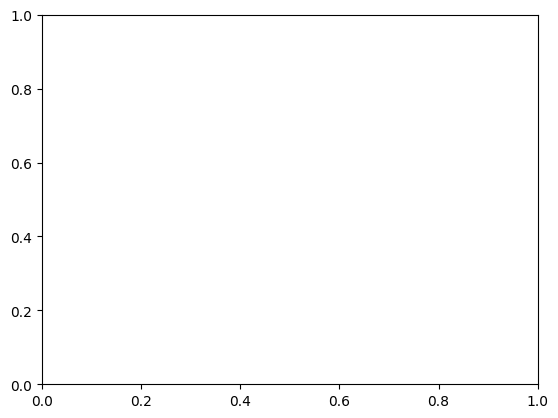

In [50]:
%matplotlib inline
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt



fs = 50
window = 'hann'
n  = 128
# STFT
f, t, Z = stft(linedata, fs=fs, window=window, nperseg=n,axis=0)
# 求幅值
Z = np.abs(Z)
# 如下图所示
plt.pcolormesh(t, f, Z, vmin = 0, vmax = Z.mean()*10)

In [9]:
linedata

array([[-660., -638., -470.],
       [-635., -589., -423.],
       [-638., -520., -387.],
       ...,
       [-652., -469., -352.],
       [-627., -503., -365.],
       [-637., -510., -276.]], dtype=float32)

In [13]:
df.rename(columns={
        "p_pick": "p_arrival_sample"  ,
        "s_pick": "s_arrival_sample"  ,
        "st_mag": "source_magnitude",
        "dis"   : "source_distance_km",
        "baz"   : "back_azimuth_deg",
        "key"   : "trace_name",
        "group" : "ev_id" #<<< --- 古早的这一行弄反了
    }, inplace=True)


In [14]:
df = df[df['source_distance_km']<110]

In [17]:
for key in ['source_magnitude','back_azimuth_deg','source_distance_km','E_S_amplitude_snr','N_S_amplitude_snr','Z_S_amplitude_snr']:
    df = df[pd.to_numeric(df[key], errors='coerce').notna()]
    df = df[df[key].notna()]

In [20]:
df['back_azimuth_deg']=df['back_azimuth_deg'].values.astype('float')

In [21]:
theory_error = []
preded_angle = []
stats = {'npts': 9000, 'sampling_rate': 50.0,'starttime': UTCDateTime(2000, 1, 1),}
fs = stats['sampling_rate']
generic_start_time = stats['starttime']
for i in tqdm(range(len(df))):
    dataset = df.iloc[i]
    linedata= dtfl[dataset['trace_name']]
    trace_z = Trace(data=linedata[...,0], header=stats|{'channel':'Z'})
    trace_n = Trace(data=linedata[...,1], header=stats|{'channel':'N'})
    trace_e = Trace(data=linedata[...,2], header=stats|{'channel':'E'})
    st = Stream(traces=[trace_z, trace_n, trace_e])
    before_p= 0.5
    after_p = 1.0
    win_len = after_p + before_p
    polarization = polarization_analysis(
        st,
        win_len = win_len,
        win_frac= 1/(win_len*fs) ,
        frqlow  = 2 , # < unnecessary for flinn method  
        frqhigh = 20, # < unnecessary for flinn method
        stime   = generic_start_time + dataset.p_arrival_sample/fs - before_p,
        etime   = generic_start_time + dataset.p_arrival_sample/fs + after_p,
        method  ='flinn'
    )

    pol = polarization
    backazimuth= pol['azimuth'][0]+180
    preded_angle.append(backazimuth)
    theory_error.append(1- np.cos((backazimuth - dataset.back_azimuth_deg)/180*np.pi))

  0%|          | 0/1747384 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
new_df = df.iloc[:len(theory_error)]

In [25]:
new_df['azimuth'] = np.array(preded_angle) - 180

/tmp/ipykernel_39378/4011092499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['azimuth'] = np.array(preded_angle) - 180


In [30]:
new_df = new_df[new_df['p_motion'].isin(['U','R'])]

In [66]:
new_df['backazimuth'] = new_df['azimuth'] #+ 180#*(new_df['p_motion'].values=='U').astype('int')

/tmp/ipykernel_39378/950218550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['backazimuth'] = new_df['azimuth'] #+ 180#*(new_df['p_motion'].values=='U').astype('int')


In [67]:
aa = new_df[new_df['p_motion']=='U']
theory_error = 1- np.cos((aa['backazimuth'].values - aa['back_azimuth_deg'].values)/180*np.pi)
theory_error

array([2.28827523e-01, 1.63769080e-03, 1.21143686e+00, ...,
       1.97289242e+00, 8.93944789e-02, 6.25173051e-02])

(array([2029.,  403.,  228.,  166.,  159.,  169.,  146.,  253.,  376.,
        1981.]),
 array([1.22861166e-09, 2.00000001e-01, 4.00000000e-01, 6.00000000e-01,
        8.00000000e-01, 9.99999999e-01, 1.20000000e+00, 1.40000000e+00,
        1.60000000e+00, 1.80000000e+00, 2.00000000e+00]),
 <BarContainer object of 10 artists>)

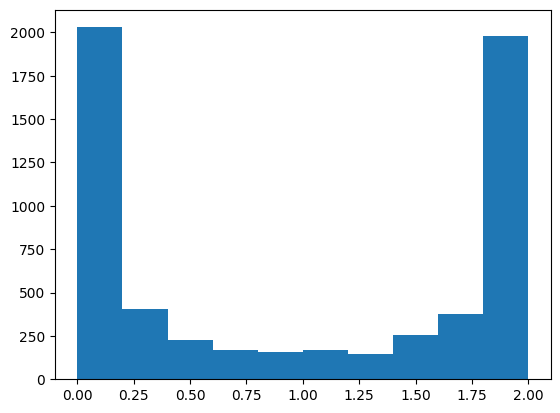

In [68]:
%matplotlib inline
plt.hist(theory_error)

# STEAD

In [5]:
import pandas as pd

In [6]:
import h5py

In [11]:
df = pd.read_csv('datasets/STEAD/BDLEELSSO/trace.fast.csv')
dtfl = h5py.File('datasets/STEAD/stead.hdf5','r')

In [16]:
theory_error = []
preded_angle = []
stats = {'npts': 6000, 'sampling_rate': 100.0,'starttime': UTCDateTime(2000, 1, 1),}
fs = stats['sampling_rate']
generic_start_time = stats['starttime']
for i in tqdm(range(len(df))):
    dataset = df.iloc[i]
    linedata= dtfl.get('data/'+str(dataset['trace_name']))[()]
    trace_e = Trace(data=linedata[...,0], header=stats|{'channel':'E'})
    trace_n = Trace(data=linedata[...,1], header=stats|{'channel':'N'})
    trace_z = Trace(data=linedata[...,2], header=stats|{'channel':'Z'})
    st = Stream(traces=[trace_z, trace_n, trace_e])
    before_p= 0.5
    after_p = 1.0
    win_len = after_p + before_p
    polarization = polarization_analysis(
        st,
        win_len = win_len,
        win_frac= 1/(win_len*fs) ,
        frqlow  = 2 , # < unnecessary for flinn method  
        frqhigh = 20, # < unnecessary for flinn method
        stime   = generic_start_time + dataset.p_arrival_sample/fs - before_p,
        etime   = generic_start_time + dataset.p_arrival_sample/fs + after_p,
        method  ='pm'
    )

    pol = polarization
    backazimuth= pol['azimuth'][0]+180
    preded_angle.append(backazimuth)
    theory_error.append(1- np.cos((backazimuth - dataset.back_azimuth_deg)/180*np.pi))

  0%|          | 0/147013 [00:00<?, ?it/s]

KeyboardInterrupt: 

(array([487., 143., 109., 110., 101., 128., 148., 172., 299., 781.]),
 array([5.18928765e-07, 2.00000272e-01, 4.00000025e-01, 5.99999777e-01,
        7.99999530e-01, 9.99999283e-01, 1.19999904e+00, 1.39999879e+00,
        1.59999854e+00, 1.79999829e+00, 1.99999805e+00]),
 <BarContainer object of 10 artists>)

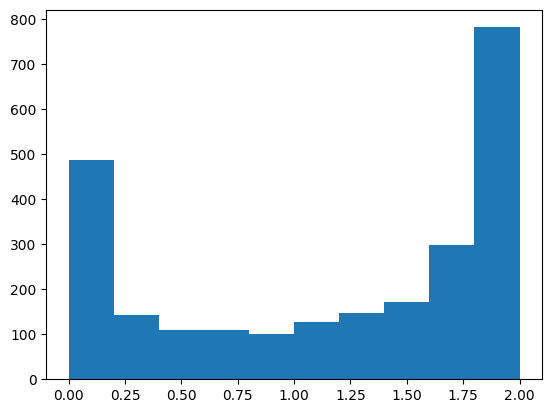

In [17]:
%matplotlib inline
plt.hist(theory_error)

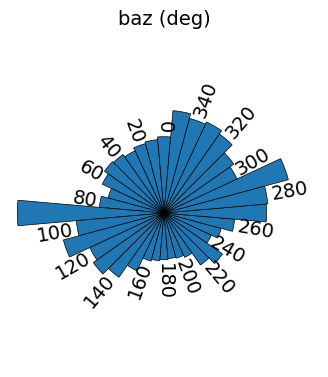

In [70]:
plot_angle(df['back_azimuth_deg'].values)

In [69]:
def plot_angle(az_list):
    az_histgram = np.histogram(az_list,bins=np.arange(0,361,10))
    # set figure size
    plt.figure(figsize=(12,4))

    # plot polar axis
    ax = plt.subplot(121, polar=True)

    # remove grid
    plt.axis('off')

    # Set the coordinates limits
    upperLimit = az_histgram[0].max()
    lowerLimit = az_histgram[0].min()

    # Compute max and min in the dataset
    max = az_histgram[0].max()

    # Let's compute heights: they are a conversion of each item value in those new coordinates
    # In our example, 0 in the dataset will be converted to the lowerLimit (10)
    # The maximum will be converted to the upperLimit (100)
    #heights = np.log10(az_histgram[0])
    heights = az_histgram[0]
    # Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi / len(az_histgram[0])

    # Compute the angle each bar is centered on:
    indexes = list(range(1, len(az_histgram[1][:-1])+1))
    angles = [((element-1) * width) +  0.5*np.pi for element in indexes] 

    # Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=1,
        linewidth=0.5, 
        edgecolor="black")

    # little space between the bar and the label
    labelPadding = 30.0

    # Add labels
    gap = 0
    for bar, angle, height, label in zip(bars, angles, heights, az_histgram[1][:-1]):

        if gap%2 == 0:
            gap += 1
        else:
            gap += 1
            continue


        # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

        # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        # Finally add the labels
        ax.text(
            x=angle, 
            y= bar.get_height()*1.05, 
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor",fontsize=14) 

    plt.title('baz (deg)',fontsize=14)